In [114]:
# !open .

In [115]:
import pandas as pd
import requests
import bs4
import math
import time
import NeoQuant as nq
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 500)

## get all company list

In [116]:
companies = nq.get_all_company_list()

## set company name

In [117]:
# company_name = '현대건설'
company_name = '케이티앤지'
company_code = nq.get_company_code(company_name, companies)
print('company name : ' + company_name)
print('company code : ' + company_code)

company name : 케이티앤지
company code : 033780


## get base profit ratio

In [118]:
base_profit_ratio = nq.get_base_profit_ratio()
base_profit_ratio

8.29

## get fnguide snapshot

In [119]:
if not company_code.startswith('A'):
    company_code = 'A' + company_code

snapshot_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=701&gicode=' + company_code
snapshot_page = requests.get(snapshot_url)
snapshot_tables = pd.read_html(snapshot_page.text)

## get stock count

In [120]:
import math

def get_total_stock_count(snapshot_tables):
    stock_count = 0

    info = snapshot_tables[0]
    info = info.set_index(info.columns[0])
    stock_count_info = info.loc['발행주식수(보통주/ 우선주)'][1]
    stock_counts = stock_count_info.split('/')
    for count in stock_counts:
#         print(count)
        stock_count = stock_count + int(count.replace(',',''))

    return stock_count

def get_self_stock_count(snapshot_tables):
    self_stock_count = 0
    info = snapshot_tables[4]
    info = info.set_index(info.columns[0])
    count = info.loc[['자기주식\xa0(자사주+자사주신탁)']]['보통주'][0]
#     print(count)
    if not math.isnan(count):
        self_stock_count = int(count)
    return self_stock_count

stock_count = get_total_stock_count(snapshot_tables) - get_self_stock_count(snapshot_tables)
print('stock count : ' + str(stock_count))

stock count : 124079923


## get asset, roe

In [121]:
def get_fr_df_index(snapshot_tables):
    fr_df_index = -1
    for num, snapshot in enumerate(snapshot_tables):
        if 'Annual' in snapshot.columns:
            if len(snapshot['Annual'].columns) > 4:
#                 print('bingo ' + str(num))
                fr_df_index = num
                break
    return fr_df_index

def get_base_year_name(fr_df):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    asset_index_name = '지배주주지분'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    stadard_col_name = ''
    roes = info.loc[roe_index_name][big_col_name]
    assets = info.loc[asset_index_name][big_col_name]
    for index in reversed(assets.index):
        if index.endswith(('(E)')):
            continue
        if not math.isnan(assets[index]) and not math.isnan(roes[index]):
            stadard_col_name = index
            break
    return stadard_col_name

def get_year_name_list(fr_df):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    asset_index_name = '지배주주지분'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    year_name_list = []
    
    year_name = ''
    roes = info.loc[roe_index_name][big_col_name]
    assets = info.loc[asset_index_name][big_col_name]
    for index in assets.index:
        if index.endswith(('(E)')):
            continue
        if not math.isnan(assets[index]) and not math.isnan(roes[index]):
            year_name = index
#             year_name = str(pd.to_datetime(year_name).year)
            year_name_list.append(year_name)
    return year_name_list

def get_roe(fr_df, base_year_name):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    roe = info.loc[roe_index_name][big_col_name, base_year_name]
    return roe

def get_net_income(fr_df, base_year_name):
    big_col_name = 'Annual'
    index_name = '당기순이익'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    income = info.loc[index_name][big_col_name, base_year_name]
    income = income * 100000000
    return income

def get_net_profit(fr_df, base_year_name):
    big_col_name = 'Annual'
    profit_index_name = '지배주주지분'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    profit = info.loc[profit_index_name][big_col_name, base_year_name]
    profit = profit * 100000000
    return profit

def get_op_profit(fr_df, base_year_name):
    big_col_name = 'Annual'
    profit_index_name = '영업이익'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    profit = info.loc[profit_index_name][big_col_name, base_year_name]
    profit = profit * 100000000
    return profit

def get_asset(fr_df, base_year_name):
    big_col_name = 'Annual'
    asset_index_name = '자산총계'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    asset = info.loc[asset_index_name][big_col_name, base_year_name]
    asset = asset * 100000000
    return asset

In [122]:
fr_df_index = get_fr_df_index(snapshot_tables)
fr_df = snapshot_tables[fr_df_index]

In [123]:
get_year_name_list(fr_df)

['2016/12', '2017/12', '2018/12', '2019/12', '2020/12']

In [124]:
price_df_tmp = nq.request_price_list(company_code, 'day', 2000)

In [125]:
price_df = price_df_tmp
price_df['price_very_low'] = 0
price_df['price_low'] = 0
price_df['price_middle'] = 0
price_df['price_high'] = 0

In [126]:
for year_name in year_name_list:
#     print(year_name)
    roe =  get_roe(fr_df, year_name)
    net_profit = get_net_profit(fr_df, year_name)
    
    price_high = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 1)
    price_middle = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 0.9)
    price_low = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 0.8)
    price_very_low = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 0.5)


    print('=====================================')
    print('base year : ' + year_name)
    print('net profit : ' + str(net_profit))
    print('roe : ' + str(roe))
    print('very low : ' + str(price_very_low))
    print('buy : below ' + str(price_low))
    print('sell 1/3 : ' + str(price_middel))
    print('sell 1/3 : ' + str(price_high))

    base_year = str(pd.to_datetime(year_name).year)
#     print(base_year)
    try:
        price_df.loc[base_year]['price_very_low'] = [price_very_low] * len(price_df.loc[base_year])
        price_df.loc[base_year]['price_low'] = [price_low] * len(price_df.loc[base_year])
        price_df.loc[base_year]['price_middle'] = [price_middle] * len(price_df.loc[base_year])
        price_df.loc[base_year]['price_high'] = [price_high] * len(price_df.loc[base_year])
    except KeyError:
        print('key error')

base year : 2016/12
net profit : 6994000000000.0
roe : 18.37
very low : 61773
buy : below 78014
sell 1/3 : 75720
sell 1/3 : 137264
base year : 2017/12
net profit : 7802500000000.0
roe : 16.37
very low : 67688
buy : below 81690
sell 1/3 : 75720
sell 1/3 : 129139
base year : 2018/12
net profit : 8114400000000.0
roe : 11.39
very low : 67285
buy : below 72383
sell 1/3 : 75720
sell 1/3 : 86723
base year : 2019/12
net profit : 8684200000000.0
roe : 12.32
very low : 72623
buy : below 79839
sell 1/3 : 75720
sell 1/3 : 100859
base year : 2020/12
net profit : 9036900000000.0
roe : 13.22
very low : 76194
buy : below 85533
sell 1/3 : 75720
sell 1/3 : 113675


## set roe manually

In [127]:
# roe = 20

## show chart

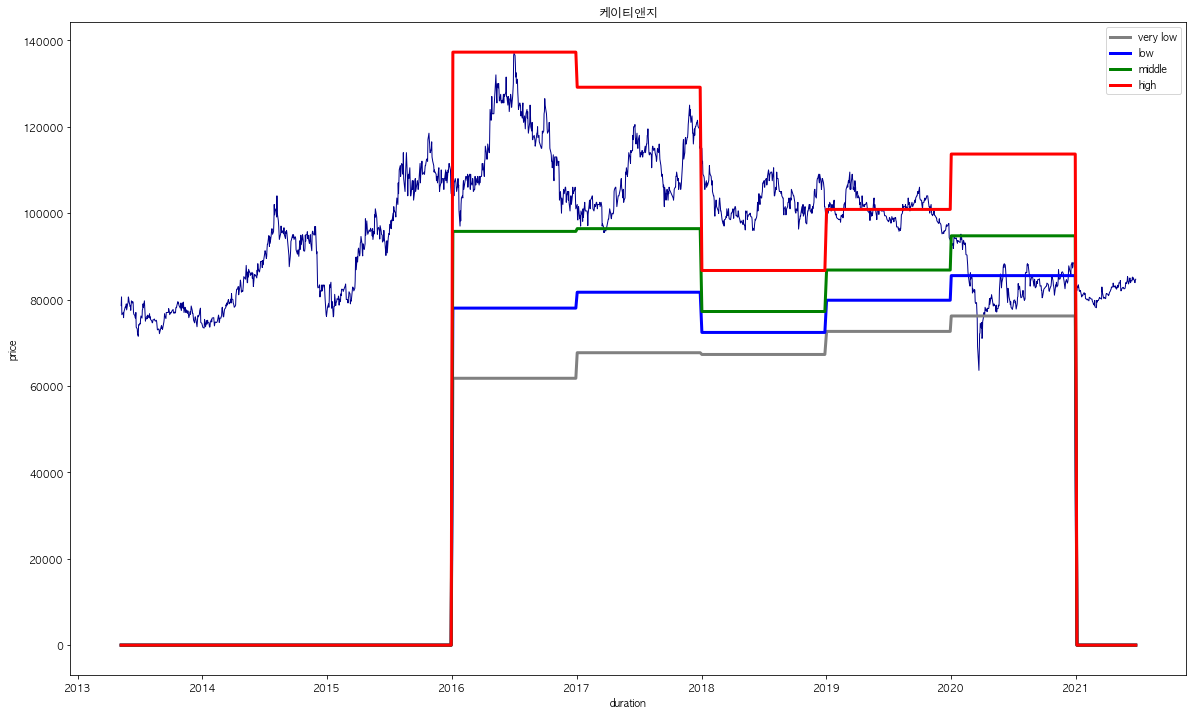

In [128]:
nq.show_price_chart(company_code, company_name, price_df)